In [1]:
# Data
import numpy as np
import pandas as pd
import geopandas as gpd

# Dates
import datetime
import time
import julian

# Database
import sqlite3
import spatialite
import shapely

# Plotting
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
conn_spa = spatialite.connect('../FPA_FOD_20170508.sqlite')
sql = '''
SELECT *, ST_AsBinary(Shape) as geom
FROM Fires 
'''
fpa = gpd.read_postgis(sql, conn_spa)
fpa.head()
conn_spa.close()

CPU times: user 1min 29s, sys: 26.3 s, total: 1min 56s
Wall time: 2min 52s


### CLEANING DATA

In [3]:
# Function to clean column types and convert datatypes

def clean_columns(df):
    # Convert Owner_code to integer
    df['OWNER_CODE'] = df['OWNER_CODE'].astype(int)

    # Convert Discovery Date to datetime format from julian format
    df['DISCOVERY_DATE'] = df['DISCOVERY_DATE'].map(lambda x: julian.from_jd(x))
    
    # Create DISCOVERY Day of Week
    df['DISCOVERY_DAY_OF_WEEK'] = df['DISCOVERY_DATE'].map(lambda x: x.weekday())
    
    # Add a column for Discovery Month and 
    df['FIRE_MONTH'] = df['DISCOVERY_DATE'].map(lambda x: x.month)

    # Convert Containment date to datetime format from julian format
    df['CONT_DATE'] = df['CONT_DATE'].map(lambda x: julian.from_jd(x) if np.isnan(x) == False else x)

    # Convert label column to integers
    df['STAT_CAUSE_CODE'] = df['STAT_CAUSE_CODE'].astype(int)
    
    df['LOG10_FIRE_SIZE'] = np.round(np.log10(df['FIRE_SIZE']),2)
    return df

fpa = clean_columns(fpa)

In [4]:
fpa.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'geom', 'DISCOVERY_DAY_OF_WEEK',
       'FIRE_MONTH', 'LOG10_FIRE_SIZE'],
      dtype='object')

## Import County data to fill in FIPs codes
- **USA_Counties.shp** is a (3221, 57) Dataframe that includes polygons of county outlines. 
- **state_codes.csv** is a (51, 3) dataset with state names, state abbreviations, and statecodes. 

In [6]:
# Import County shapes
county_shape = gpd.read_file('./data/USA_Counties.shp')

# Import state codes
states = pd.read_csv('./data/state_codes.csv')

# Extract state_codes and incorporate it into count_shape dataset
county_shape['STATE_CODE'] = pd.merge(county_shape, states, how = 'left',left_on = 'STATE_NAME',right_on = 'State')['Code']

In [7]:
# Function to return county name, state fips, and county fips for a given point
#  Input (point, state) - state is included to speed up the operation
def check_point_by_state(point, state):
    # Extract only counties from the given state
    state_counties = county_shape[county_shape['STATE_CODE'] == state][['NAME','STATE_FIPS','CNTY_FIPS', 'geometry']]
    
    # Loop over all counties in given state
    for i in state_counties.index:
        # Check if county matches
        check = point.within(state_counties['geometry'][i])
        # If so, return value
        if check == True:
            return (state_counties.loc[i,'NAME'],
                    state_counties.loc[i,'STATE_FIPS'],
                    state_counties.loc[i,'CNTY_FIPS'])
            # Break from the loop
            break
    # If we end the loop without a break, return nan's
    return (np.nan,np.nan, np.nan)

In [8]:
# Create a mask of null fips codes
null_fips_mask = (fpa['FIPS_CODE'].isna())

# Create list of indexs for null fips codes
null_fips_index = null_fips_mask[null_fips_mask==True].index

# Create lists of geoms and states
null_fips_geoms = fpa['geom'][null_fips_mask]
null_fips_states = fpa['STATE'][null_fips_mask]

# Create a GeoDataFrame of the points and states
gpd.GeoDataFrame({'geom':null_fips_geoms, 'state':null_fips_states})


geom state
7        POINT (-122.43389 40.96806)    CA
8        POINT (-122.28333 41.23361)    CA
47       POINT (-105.18306 39.29222)    CO
61       POINT (-105.98361 38.91333)    CO
62       POINT (-106.36750 39.10028)    CO
...                              ...   ...
1880460  POINT (-122.38937 40.48164)    CA
1880461  POINT (-120.93857 37.61762)    CA
1880462  POINT (-120.93857 37.61762)    CA
1880463  POINT (-120.89836 37.67223)    CA
1880464  POINT (-116.83095 34.26322)    CA

[678148 rows x 2 columns]

In [9]:
len(null_fips_index)

678148

In [10]:
%%time
fips_list = []
for step,i in enumerate(null_fips_index):
    # Get geometry and state from series with null masks
    p1 = null_fips_geoms[i]
    state = null_fips_states[i]
    (county, state_fips, county_fips) = check_point_by_state(p1, state)
    fips_list.append(county_fips)
    if step %10000 == 0: print(step, time.strftime("%H:%M:%S", time.localtime()))
fips_fillins_3 = pd.Series(fips_list,
                         index = null_fips_index, 
                         name = 'COUNTY_FIPS')

0 15:35:31
10000 15:39:04
20000 15:42:27
30000 15:44:16
40000 15:47:24
50000 15:49:13
60000 15:51:02
70000 15:52:51
80000 15:54:35
90000 15:56:30
100000 15:58:09
110000 16:00:16
120000 16:02:14
130000 16:04:20
140000 16:07:03
150000 16:09:10
160000 16:10:25
170000 16:11:56
180000 16:14:38
190000 16:15:53
200000 16:17:03
210000 16:18:51
220000 16:20:18
230000 16:22:04
240000 16:24:01
250000 16:27:49
260000 16:31:13
270000 16:33:33
280000 16:35:38
290000 16:37:10
300000 16:38:37
310000 16:39:59
320000 16:41:22
330000 16:42:48
340000 16:44:30
350000 16:46:10
360000 16:48:56
370000 16:51:15
380000 16:53:01
390000 16:54:32
400000 16:56:22
410000 16:58:15
420000 17:00:11
430000 17:01:34
440000 17:06:06
450000 17:08:13
460000 17:10:11
470000 17:12:14
480000 17:14:04
490000 17:17:47
500000 17:21:03
510000 17:26:00
520000 17:29:47
530000 17:32:44
540000 17:35:34
550000 17:37:31
560000 17:39:51
570000 17:41:31
580000 17:42:41
590000 17:44:08
600000 17:45:39
610000 17:47:02
620000 17:48:40
630000

In [13]:
len(fips_fillins_3)

678148

In [ ]:
fips_fillins = fips_fillins.append(fips_fillins_3)

In [ ]:
fips_fillins

In [14]:
# Merge extracted fips values to original fpa dataset
fpa = pd.merge(fpa, fips_fillins_3, how = 'left', right_index = True, left_index = True)

In [15]:
fpa.shape

(1880465, 44)

In [ ]:
county_shape.columns

In [ ]:
states['Code'].head()

In [48]:
# Add on STATE_FIPS to fpa dataframe
fpa = pd.merge(fpa, county_shape.groupby(by = 'STATE_CODE')['STATE_FIPS'].first(),
         how = 'left',
         left_on = 'STATE', right_index = True)

In [50]:
fpa.head()

OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  ... COUNTY FIPS_CODE  \
0                  0511     Plumas National Forest  ...     63       063   
1                  0503   Eldorado National Forest  ...     61       061   
2                  0503   Eldorado National Forest  ...     17       017   
3                  0503   Eldorado National Forest  ...      3       003   
4                  0503   Eldorado National Forest  ...      3       003   

   FIPS_NAME                                              Shape  \
0     Plumas  b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...   
1     Placer  b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...   
2  El Dorado  b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...   
3     Alpine  b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...   
4     Alpine  b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...   

                          geom DISCOVERY_DAY_OF_WEEK FIRE_MONTH  \
0  POINT (-121.00583 40.03694)                     2          2   
1  POINT (-120.40444 38.93306)                     2          5   
2  POINT (-120.73556 38.98417)                     0          5   
3  POINT (-119.91333 38.55917)                     0          6   
4  POINT (-119.93306 38.55917)                     0          6   

  LOG10_FIRE_SIZE COUNTY_FIPS  STATE_FIPS  
0            -1.0         NaN          06  
1            -0.6         NaN          06  
2            -1.0         NaN          06  
3            -1.0         NaN          06  
4            -1.0         NaN          06  

[5 rows x 45 columns]

In [56]:
(fpa['FIPS_COMB'].astype(str).map(lambda x: len(x)) !=5).sum()

23370

In [51]:
fpa['FIPS_COMB'] = fpa['STATE_FIPS'] + fpa['COUNTY_FIPS'].fillna('')+fpa['FIPS_CODE'].fillna('')

In [52]:
fpa.head()

OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  ... FIPS_CODE  FIPS_NAME  \
0                  0511     Plumas National Forest  ...       063     Plumas   
1                  0503   Eldorado National Forest  ...       061     Placer   
2                  0503   Eldorado National Forest  ...       017  El Dorado   
3                  0503   Eldorado National Forest  ...       003     Alpine   
4                  0503   Eldorado National Forest  ...       003     Alpine   

                                               Shape  \
0  b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...   
1  b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...   
2  b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...   
3  b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...   
4  b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...   

                          geom DISCOVERY_DAY_OF_WEEK FIRE_MONTH  \
0  POINT (-121.00583 40.03694)                     2          2   
1  POINT (-120.40444 38.93306)                     2          5   
2  POINT (-120.73556 38.98417)                     0          5   
3  POINT (-119.91333 38.55917)                     0          6   
4  POINT (-119.93306 38.55917)                     0          6   

  LOG10_FIRE_SIZE COUNTY_FIPS STATE_FIPS  FIPS_COMB  
0            -1.0         NaN         06      06063  
1            -0.6         NaN         06      06061  
2            -1.0         NaN         06      06017  
3            -1.0         NaN         06      06003  
4            -1.0         NaN         06      06003  

[5 rows x 46 columns]

In [ ]:
# Check how many nulls there are in bot fips codes
(fpa['FIPS_CODE'].isna() & fpa['COUNTY_FIPS'].isna()).sum()

In [ ]:
# Check how many have both values
(fpa['FIPS_CODE'].notna() & fpa['COUNTY_FIPS'].notna()).sum()

In [ ]:
(fpa['FIPS_COMB'].isna()).sum()

In [ ]:
(fpa['STATE_FIPS'].isna()).sum()

In [ ]:
fpa[((fpa['FIPS_CODE'].isna()) & (fpa['COUNTY_FIPS'].isna()) & (fpa['STATE']!='PR'))].iloc[:,10:30]

In [ ]:
fpa.head()

In [ ]:
%%time
fpa.to_csv('./data/large_fire_list.csv')

## Checking for Nulls

Fire Size and Class

In [ ]:
((fpa['FIRE_SIZE'].isna()).sum(),(fpa['FIRE_SIZE_CLASS'].isna()).sum())

State and County

In [ ]:
(fpa['STATE'].isna()).sum(), (fpa['COUNTY'].isna()).sum()

In [ ]:
fpa[(fpa['FIPS_CODE'].isna())][['LATITUDE', 'LONGITUDE']]

Fips codes and names

In [ ]:
(fpa['FIPS_CODE'].isna()).sum(), (fpa['FIPS_NAME'].isna()).sum()

In [ ]:
(fpa['DISCOVERY_TIME'].isna()).sum(), (fpa['DISCOVERY_DATE'].isna()).sum()

Discovery Date and Containment Dates

In [ ]:
((fpa['DISCOVERY_DATE'].isna()).sum(), (fpa['CONT_DATE'].isna()).sum())

Latitude and Longitude coordinates

In [ ]:
((fpa['LATITUDE'].isna()).sum(), (fpa['LONGITUDE'].isna()).sum())

Cause codes and descriptions

In [ ]:
((fpa['STAT_CAUSE_CODE'].isna()).sum(),(fpa['STAT_CAUSE_DESCR'].isna()).sum())

Owner Code

In [ ]:
(fpa['OWNER_CODE'].isna()).sum()

MTBS Data

In [ ]:
(fpa['MTBS_ID'].isna()).sum(), (fpa['MTBS_FIRE_NAME'].isna()).sum()

## Filter data columns

In [ ]:
mask = (fpa['STATE'] == 'CA')

In [ ]:
fpa[mask].shape

In [ ]:
# Checking causes for errors
for i in range(1,14):
    mask = (fpa['STAT_CAUSE_CODE'] == i)
    desc = fpa[mask]['STAT_CAUSE_DESCR'].iloc[0]
    errors = (fpa[mask]['STAT_CAUSE_DESCR'] != desc).sum()
    print(f'Checking STAT_CAUSE_CODE:{i}, {desc}\n\tHas {errors} mismatches')

## EDA

| value | Description |
| ----- | ----------- |
| 1 | Lightning |
| 2 | Equipment Use |
| 3 | Smoking |
| 4 | Campfire |
| 5 | Debris Burning |
| 6 | Railroad |
| 7 | Arson |
| 8 | Children |
| 9 | Miscellaneous |
| 10 | Fireworks |
| 11 | Powerline |
| 12 | Structure |
| 13 | Missing/Undefined |

In [212]:
cause_dict = {
    1:{'category_id':0, 'label':'Lightning', 'category':'Natural'},
    2:{'category_id':1, 'label':'Equipment Use', 'category':'Human'},
    3:{'category_id':1, 'label':'Smoking', 'category':'Human'},
    4:{'category_id':1, 'label':'Campfire', 'category':'Human'},
    5:{'category_id':1, 'label':'Debris Burning', 'category':'Human'},
    6:{'category_id':1, 'label':'Railroad', 'category':'Human'},
    7:{'category_id':1, 'label':'Arson', 'category':'Human'},
    8:{'category_id':1, 'label':'Children', 'category':'Human'},
    9:{'category_id':2, 'label':'Miscellaneous', 'category':'Other'},
    10:{'category_id':1, 'label':'Fireworks', 'category':'Human'},
    11:{'category_id':1, 'label':'Powerline', 'category':'Human'},
    12:{'category_id':1, 'label':'Structure', 'category':'Human'},
    13:{'category_id':2, 'label':'Missing/Undefined', 'category':'Other'}
}

### Distribution of Fire Causes
The data provide a total of 13 causes, ranging from natural causes such as Lightning, and malicious causes such as Arson.

In [213]:
[cause_dict[i]['label'] for i in fires_by_cause.index]

['Lightning',
 'Equipment Use',
 'Smoking',
 'Campfire',
 'Debris Burning',
 'Railroad',
 'Arson',
 'Children',
 'Miscellaneous',
 'Fireworks',
 'Powerline',
 'Structure',
 'Missing/Undefined']

In [210]:
# Grouping data by cause
fires_by_cause = fpa.groupby(by = ['STAT_CAUSE_CODE']).agg({'OBJECTID':'count', 'FIRE_SIZE':['sum', 'max', 'mean']})

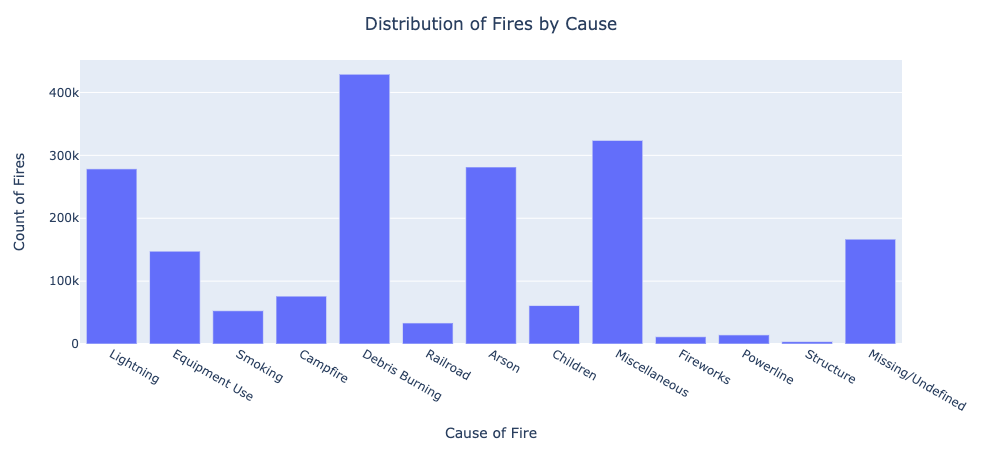

In [220]:
fig = px.bar(x = [cause_dict[i]['label'] for i in fires_by_cause.index], y = fires_by_cause['OBJECTID']['count'])
fig.update_layout(title = 'Distribution of Fires by Cause', 
                 xaxis_title = 'Cause of Fire',
                 yaxis_title = 'Count of Fires', 
                 title_x = 0.5)
fig.show()

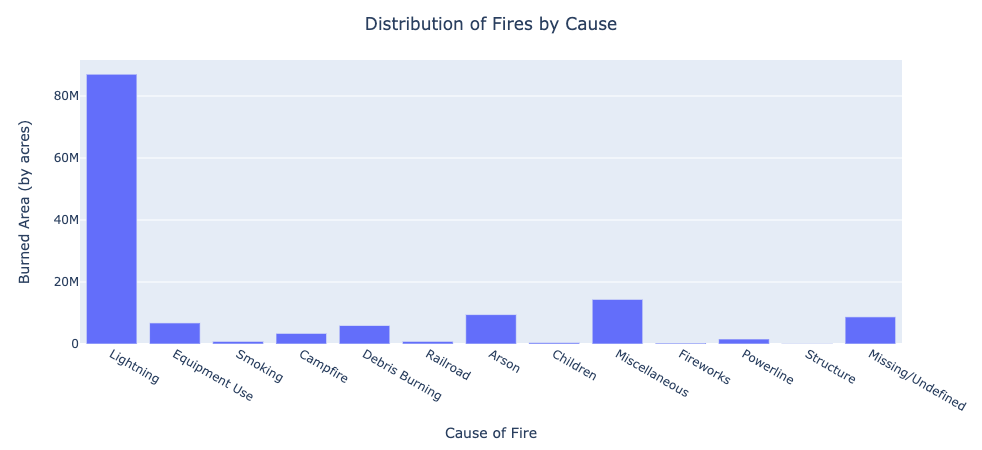

In [222]:
fig = px.bar(x = [cause_dict[i]['label'] for i in fires_by_cause.index], y = fires_by_cause['FIRE_SIZE']['sum'])
fig.update_layout(title = 'Distribution of Fires by Cause', 
                 xaxis_title = 'Cause of Fire',
                 yaxis_title = 'Burned Area (by acres)',
                 title_x = 0.5)

### Distribution of Fire Sizes

In [198]:
# Check for unique Classes
fpa['FIRE_SIZE_CLASS'].unique()

array(['A', 'B', 'G', 'C', 'D', 'F', 'E'], dtype=object)

Looks like G is our largest category from all available fire sizes

| Value | Description |
| :---: | :---: |
|   A   | Greater than 0 but less than or equal to 0.25 Acres |
|   B   | 0.26 to 9.9 Acres |
|   C   | 10.0 to 99.9 Acres |
|   D   | 100 to 299 Acres |
|   E   | 300 to 999 Acres |
|   F   | 1000 to 4999 Acres |
|   G   | 5000 to 9999 Acres |
|   H   | 10000 to 49999 Acres |
|   I   | 50000 to 99999 Acres |
|   J   | 100000 to 499999 Acres |
|   K   | 500000 to 999999 Acres |
|   L   | 1000000 + Acres |

In [224]:
fire_by_class = fpa.groupby(by = 'FIRE_SIZE_CLASS').agg({'OBJECTID':'count', 'FIRE_SIZE':['sum', 'max', 'mean']})

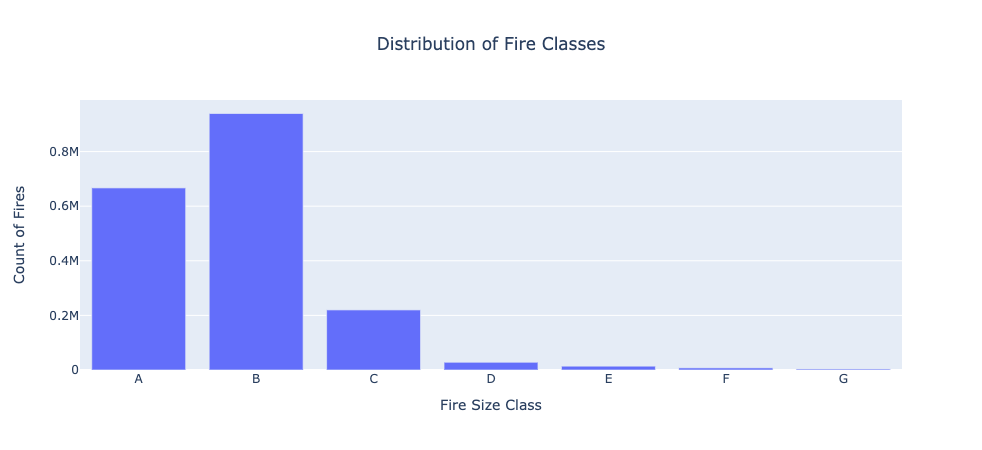

In [225]:
fig = px.bar(x = fire_by_class['OBJECTID'].index, 
       y = fire_by_class['OBJECTID']['count'], 
       title = 'Distribution of Fire Classes')
fig.update_layout(title_x = 0.5, 
                  xaxis_title="Fire Size Class", 
                  yaxis_title = 'Count of Fires')
fig.show()

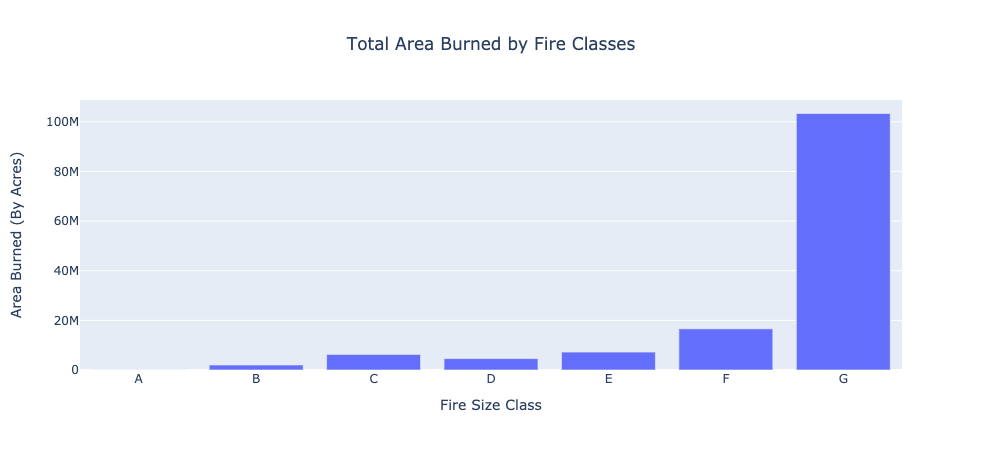

In [226]:
fig = px.bar(x = fire_by_class['OBJECTID'].index, 
       y = fire_by_class['FIRE_SIZE']['sum'], 
       title = 'Total Area Burned by Fire Classes')
fig.update_layout(title_x = 0.5, 
                  xaxis_title="Fire Size Class", 
                  yaxis_title = 'Area Burned (By Acres)')
fig.show()

### Fire Size Class by State

In [137]:
def state_class_count(df):
    fires_by_state_class = df.groupby(by = ['STATE', 'FIRE_SIZE_CLASS'])['OBJECTID'].count()
    class_list = {'A':fires_by_state_class.loc[:,'A'], 
                  'B':fires_by_state_class.loc[:,'B'],
                  'C':fires_by_state_class.loc[:,'C'], 
                  'D':fires_by_state_class.loc[:,'D'], 
                  'E':fires_by_state_class.loc[:,'E'], 
                  'F':fires_by_state_class.loc[:,'F'],
                  'G':fires_by_state_class.loc[:,'G'], 
                  'TOTAL':fires_by_state_class.groupby('STATE').sum()
    }
    return pd.DataFrame(class_list)

state_class_fires = state_class_count(fpa)

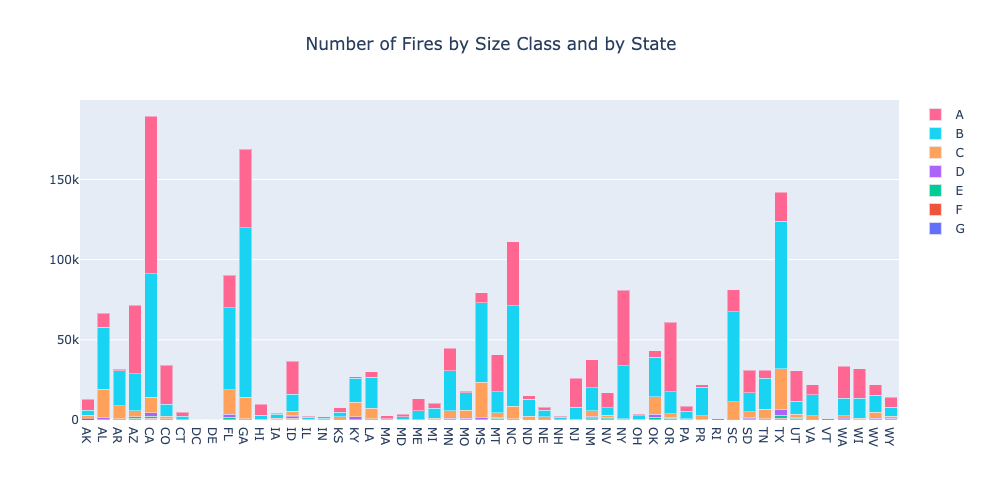

In [138]:
fig = go.Figure(data=[
    go.Bar(name = 'G',x = state_class_fires.index,
          y = state_class_fires['G']),
    go.Bar(name = 'F',x = state_class_fires.index, 
          y = state_class_fires['F']),
    go.Bar(name = 'E',x = state_class_fires.index,
           y = state_class_fires['E']),
    go.Bar(name = 'D',x = state_class_fires.index,
           y = state_class_fires['D']),
    go.Bar(name = 'C',x = state_class_fires.index,
           y = state_class_fires['C']),
    go.Bar(name = 'B',x = state_class_fires.index,
           y = state_class_fires['B']),
    go.Bar(name = 'A',x = state_class_fires.index,
           y = state_class_fires['A'])
])

fig.update_layout(barmode='stack', 
                  width=1000,
                  height=500, 
                  title = 'Number of Fires by Size Class and by State', 
                  title_x = 0.5)
fig.show()

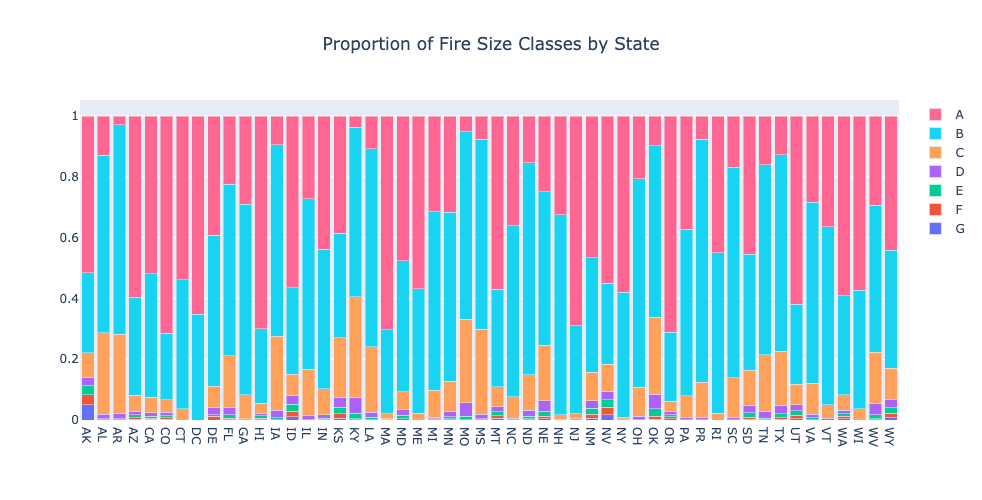

In [124]:
fig = go.Figure(data=[
    go.Bar(name = 'G',x = state_class_fires.index,
          y = state_class_fires['G']/state_class_fires['TOTAL']),
    go.Bar(name = 'F',x = state_class_fires.index, 
          y = state_class_fires['F']/state_class_fires['TOTAL']),
    go.Bar(name = 'E',x = state_class_fires.index,
           y = state_class_fires['E']/state_class_fires['TOTAL']),
    go.Bar(name = 'D',x = state_class_fires.index,
           y = state_class_fires['D']/state_class_fires['TOTAL']),
    go.Bar(name = 'C',x = state_class_fires.index,
           y = state_class_fires['C']/state_class_fires['TOTAL']),
    go.Bar(name = 'B',x = state_class_fires.index,
           y = state_class_fires['B']/state_class_fires['TOTAL']),
    go.Bar(name = 'A',x = state_class_fires.index,
           y = state_class_fires['A']/state_class_fires['TOTAL'])
])
                
fig.update_layout(barmode='stack', 
                  width=1000,
                  height=500, 
                  title = 'Proportion of Fire Size Classes by State', 
                  title_x = 0.5)
fig.show()

### Acres of Land Burned by State

In [172]:
def size_by_state_area(df):
    fires_by_state_area = df.groupby(by = ['STATE', 'FIRE_SIZE_CLASS']).agg({'FIRE_SIZE':['sum', 'max', 'mean']})['FIRE_SIZE']
    class_list = {'A':fires_by_state_area['sum'].loc[:,'A'], 
                  'B':fires_by_state_area['sum'].loc[:,'B'],
                  'C':fires_by_state_area['sum'].loc[:,'C'], 
                  'D':fires_by_state_area['sum'].loc[:,'D'], 
                  'E':fires_by_state_area['sum'].loc[:,'E'], 
                  'F':fires_by_state_area['sum'].loc[:,'F'],
                  'G':fires_by_state_area['sum'].loc[:,'G'], 
                  'TOTAL':fires_by_state_area['sum'].groupby('STATE').sum()
    }
    return pd.DataFrame(class_list)

state_class_area = size_by_state_area(fpa)

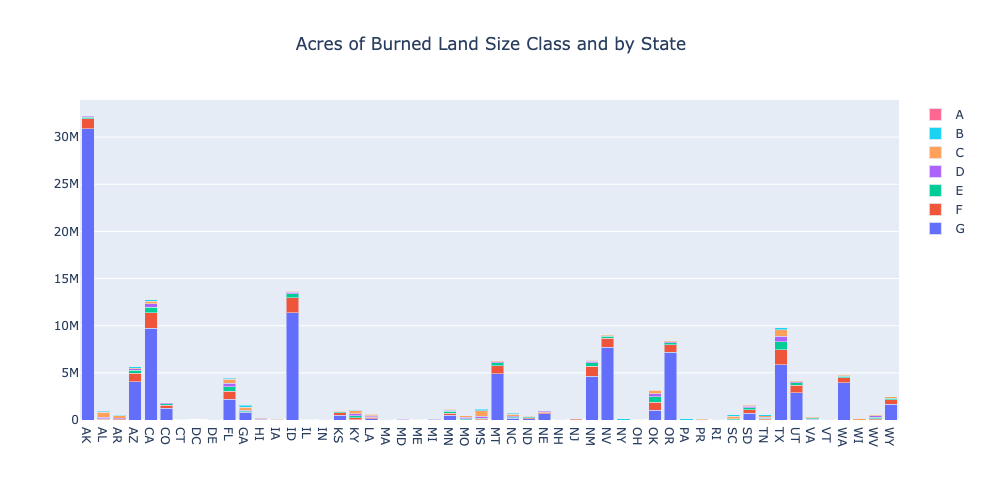

In [175]:
fig = go.Figure(data=[
    go.Bar(name = 'G',x = state_class_area.index,
          y = state_class_area['G']),
    go.Bar(name = 'F',x = state_class_area.index, 
          y = state_class_area['F']),
    go.Bar(name = 'E',x = state_class_area.index,
           y = state_class_area['E']),
    go.Bar(name = 'D',x = state_class_area.index,
           y = state_class_area['D']),
    go.Bar(name = 'C',x = state_class_area.index,
           y = state_class_area['C']),
    go.Bar(name = 'B',x = state_class_area.index,
           y = state_class_area['B']),
    go.Bar(name = 'A',x = state_class_area.index,
           y = state_class_area['A'])
])

fig.update_layout(barmode='stack', 
                  width=1000,
                  height=500, 
                  title = 'Acres of Burned Land Size Class and by State', 
                  title_x = 0.5)
fig.show()

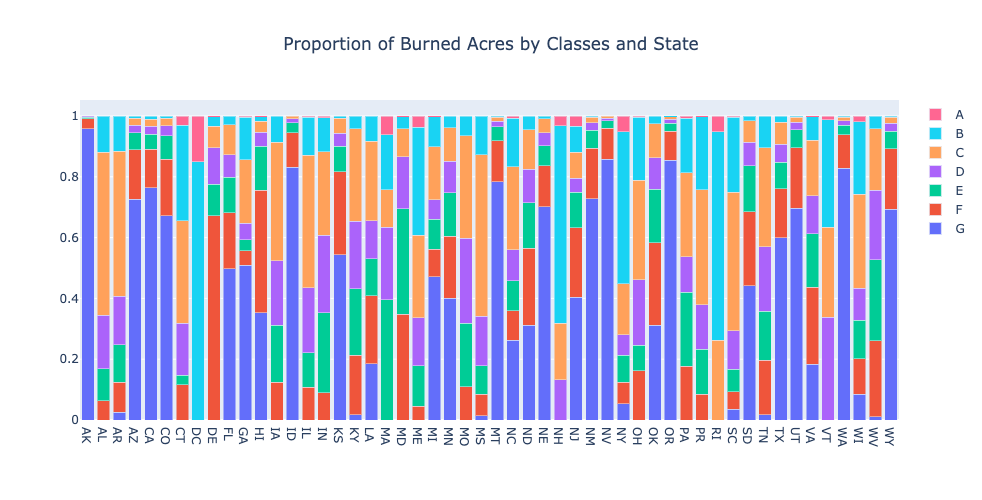

In [176]:
fig = go.Figure(data=[
    go.Bar(name = 'G',x = state_class_area.index,
          y = state_class_area['G']/state_class_area['TOTAL']),
    go.Bar(name = 'F',x = state_class_area.index, 
          y = state_class_area['F']/state_class_area['TOTAL']),
    go.Bar(name = 'E',x = state_class_area.index,
           y = state_class_area['E']/state_class_area['TOTAL']),
    go.Bar(name = 'D',x = state_class_area.index,
           y = state_class_area['D']/state_class_area['TOTAL']),
    go.Bar(name = 'C',x = state_class_area.index,
           y = state_class_area['C']/state_class_area['TOTAL']),
    go.Bar(name = 'B',x = state_class_area.index,
           y = state_class_area['B']/state_class_area['TOTAL']),
    go.Bar(name = 'A',x = state_class_area.index,
           y = state_class_area['A']/state_class_area['TOTAL'])
])
                
fig.update_layout(barmode='stack', 
                  width=1000,
                  height=500, 
                  title = 'Proportion of Burned Acres by Classes and State', 
                  title_x = 0.5)
fig.show()

### Count of Fires by Causes

In [192]:
def cause_by_state_count(df):
    cause_state_count = df.groupby(by = ['STATE', 'STAT_CAUSE_CODE'])['OBJECTID'].count()
    class_list = {'1':cause_state_count.loc[:,1], 
                  '2':cause_state_count.loc[:,2],
                  '3':cause_state_count.loc[:,3], 
                  '4':cause_state_count.loc[:,4], 
                  '5':cause_state_count.loc[:,5], 
                  '6':cause_state_count.loc[:,6],
                  '7':cause_state_count.loc[:,7], 
                  '8':cause_state_count.loc[:,8], 
                  '9':cause_state_count.loc[:,9], 
                  '10':cause_state_count.loc[:,10], 
                  '11':cause_state_count.loc[:,11], 
                  '12':cause_state_count.loc[:,12], 
                  '13':cause_state_count.loc[:,13], 
                  'TOTAL':cause_state_count.groupby('STATE').sum()
    }
    return pd.DataFrame(class_list)

cause_state_count = cause_by_state_count(fpa)

In [ ]:
cause_dict = {
    1:{'category_id':0, 'label':'Lightning', 'category':'Natural'},
    2:{'category_id':1, 'label':'Equipment Use', 'category':'Human'},
    3:{'category_id':1, 'label':'Smoking', 'category':'Human'},
    4:{'category_id':1, 'label':'Campfire', 'category':'Human'},
    5:{'category_id':1, 'label':'Debris Burning', 'category':'Human'},
    6:{'category_id':1, 'label':'Railroad', 'category':'Human'},
    7:{'category_id':1, 'label':'Arson', 'category':'Human'},
    8:{'category_id':1, 'label':'Children', 'category':'Human'},
    9:{'category_id':2, 'label':'Miscellaneous', 'category':'Other'},
    10:{'category_id':1, 'label':'Fireworks', 'category':'Human'},
    11:{'category_id':1, 'label':'Powerline', 'category':'Human'},
    12:{'category_id':1, 'label':'Structure', 'category':'Human'},
    13:{'category_id':2, 'label':'Missing/Undefined', 'category':'Other'}
}

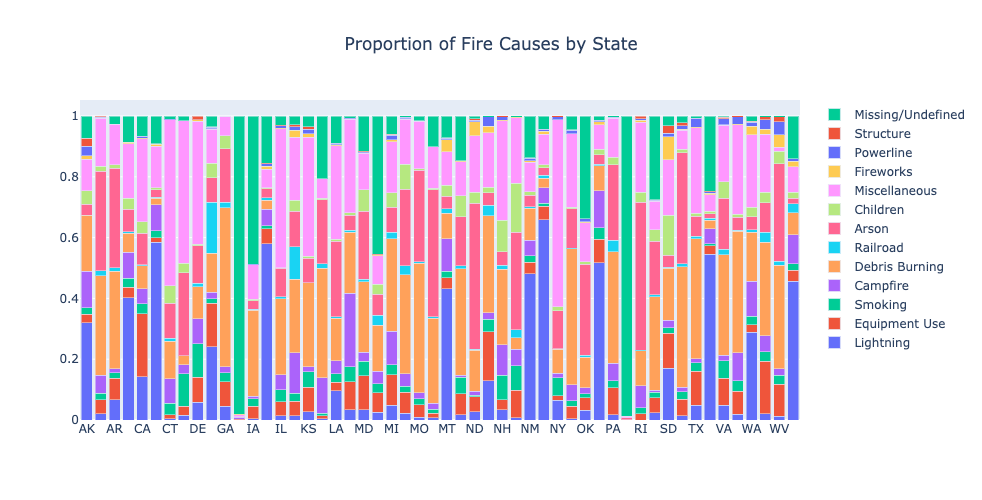

In [197]:
fig = go.Figure(data=[
    go.Bar(name = 'Lightning',x = cause_state_count.index,
          y = cause_state_count['1']/cause_state_count['TOTAL']),
    go.Bar(name = 'Equipment Use',x = cause_state_count.index, 
          y = state_class_area['2']/cause_state_count['TOTAL']),
    go.Bar(name = 'Smoking',x = cause_state_count.index,
           y = cause_state_count['3']/cause_state_count['TOTAL']),
    go.Bar(name = 'Campfire',x = cause_state_count.index,
           y = cause_state_count['4']/cause_state_count['TOTAL']),
    go.Bar(name = 'Debris Burning',x = cause_state_count.index,
           y = cause_state_count['5']/cause_state_count['TOTAL']),
    go.Bar(name = 'Railroad',x = cause_state_count.index,
           y = cause_state_count['6']/cause_state_count['TOTAL']),
    go.Bar(name = 'Arson',x = cause_state_count.index,
           y = cause_state_count['7']/cause_state_count['TOTAL']), 
    go.Bar(name = 'Children',x = cause_state_count.index,
           y = cause_state_count['8']/cause_state_count['TOTAL']), 
    go.Bar(name = 'Miscellaneous',x = cause_state_count.index,
           y = cause_state_count['9']/cause_state_count['TOTAL']), 
    go.Bar(name = 'Fireworks',x = cause_state_count.index,
           y = cause_state_count['10']/cause_state_count['TOTAL']), 
    go.Bar(name = 'Powerline',x = cause_state_count.index,
           y = cause_state_count['11']/cause_state_count['TOTAL']), 
    go.Bar(name = 'Structure',x = cause_state_count.index,
           y = cause_state_count['12']/cause_state_count['TOTAL']), 
    go.Bar(name = 'Missing/Undefined',x = cause_state_count.index,
           y = cause_state_count['13']/cause_state_count['TOTAL'])
])

fig.update_layout(barmode='stack', 
                  width=1000,
                  height=500,
                  title = 'Proportion of Fire Causes by State', 
                  title_x = 0.5)
fig.show()

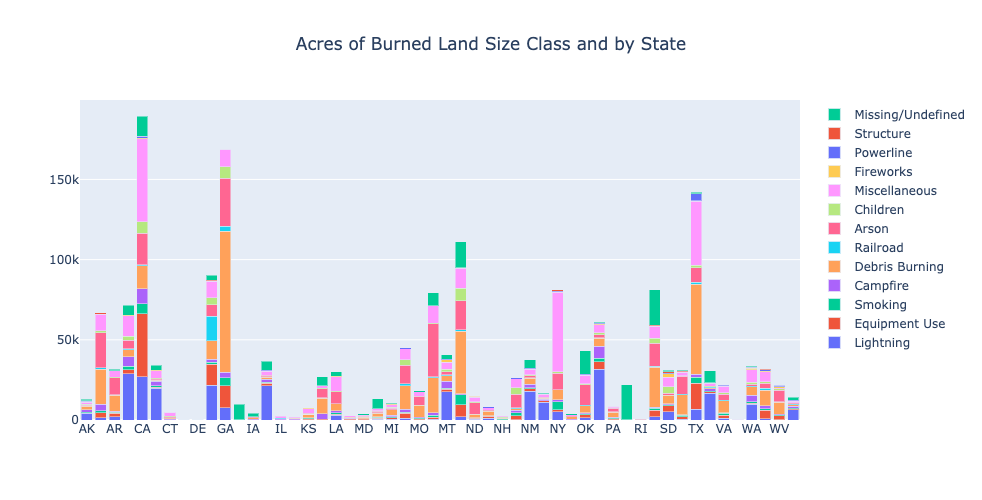

In [196]:
fig = go.Figure(data=[
    go.Bar(name = 'Lightning',x = cause_state_count.index,
          y = cause_state_count['1']),
    go.Bar(name = 'Equipment Use',x = cause_state_count.index, 
          y = state_class_area['2']),
    go.Bar(name = 'Smoking',x = cause_state_count.index,
           y = cause_state_count['3']),
    go.Bar(name = 'Campfire',x = cause_state_count.index,
           y = cause_state_count['4']),
    go.Bar(name = 'Debris Burning',x = cause_state_count.index,
           y = cause_state_count['5']),
    go.Bar(name = 'Railroad',x = cause_state_count.index,
           y = cause_state_count['6']),
    go.Bar(name = 'Arson',x = cause_state_count.index,
           y = cause_state_count['7']), 
    go.Bar(name = 'Children',x = cause_state_count.index,
           y = cause_state_count['8']), 
    go.Bar(name = 'Miscellaneous',x = cause_state_count.index,
           y = cause_state_count['9']), 
    go.Bar(name = 'Fireworks',x = cause_state_count.index,
           y = cause_state_count['10']), 
    go.Bar(name = 'Powerline',x = cause_state_count.index,
           y = cause_state_count['11']), 
    go.Bar(name = 'Structure',x = cause_state_count.index,
           y = cause_state_count['12']), 
    go.Bar(name = 'Missing/Undefined',x = cause_state_count.index,
           y = cause_state_count['13'])
])

fig.update_layout(barmode='stack', 
                  width=1000,
                  height=500, 
                  title = 'Count of Fire Causes by State', 
                  title_x = 0.5)
fig.show()

In [180]:
fpa['STAT_CAUSE_CODE'].unique()

array([ 9,  1,  5,  4,  2,  7,  8,  6,  3, 11, 12, 10, 13])

## Mapping

In [227]:
fires_by_year = fpa.groupby(by = ['STATE', 'FIRE_YEAR']).agg({'OBJECTID':'count', 'FIRE_SIZE':['sum', 'max', 'mean']})

fires_by_year['STATE'] = fires_by_year.index.get_level_values(0)
fires_by_year['FIRE_YEAR'] = fires_by_year.index.get_level_values(1)
fires_by_year['FIRE_COUNT'] = fires_by_year['OBJECTID']['count']
fires_by_year['FIRE_SIZE_SUM_log'] = np.log10(fires_by_year['FIRE_SIZE']['sum'])
fires_by_year['FIRE_SIZE_SUM_log'] = np.log10(fires_by_year['FIRE_SIZE']['sum'])

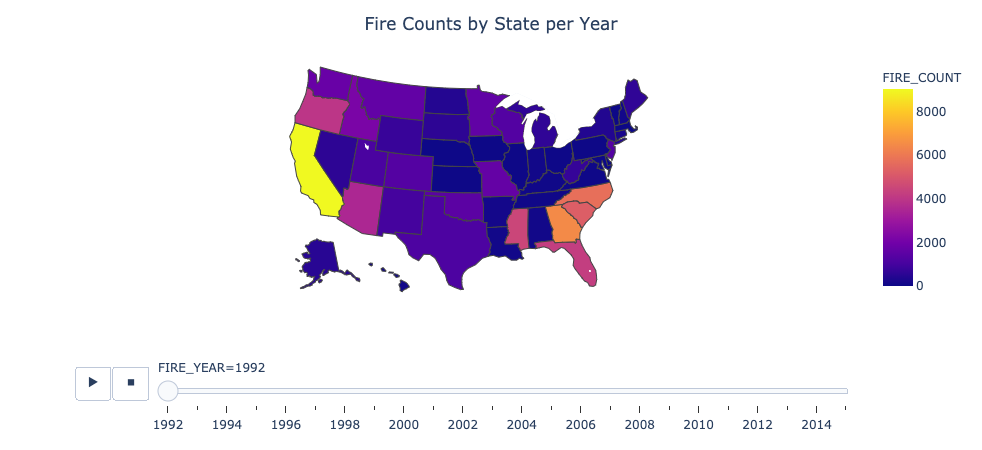

In [228]:
fig = px.choropleth(data_frame = fires_by_year, 
                  locations = fires_by_year['STATE'],
                  color = 'FIRE_COUNT',
                  range_color = [0,9000],
                  locationmode = 'USA-states',
                  animation_frame = 'FIRE_YEAR')

fig.update_layout(geo_scope = 'usa', title = 'Fire Counts by State per Year', title_x=0.5)

### 

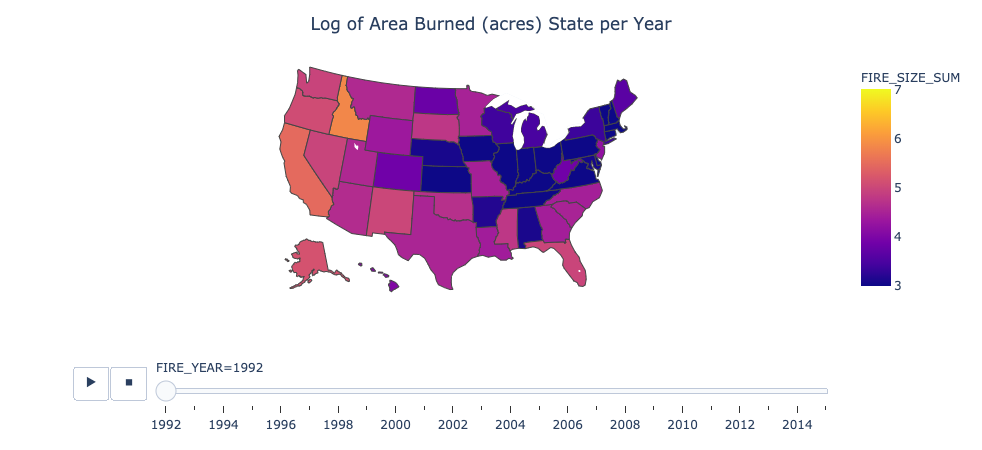

In [232]:
fig = px.choropleth(data_frame = fires_by_year, 
                  locations = fires_by_year['STATE'],
                  color = 'FIRE_SIZE_SUM',
                  range_color = [3,7],
                  locationmode = 'USA-states',
                  animation_frame = 'FIRE_YEAR')

fig.update_layout(geo_scope = 'usa', title = 'Log of Area Burned (acres) State per Year', title_x=0.5)

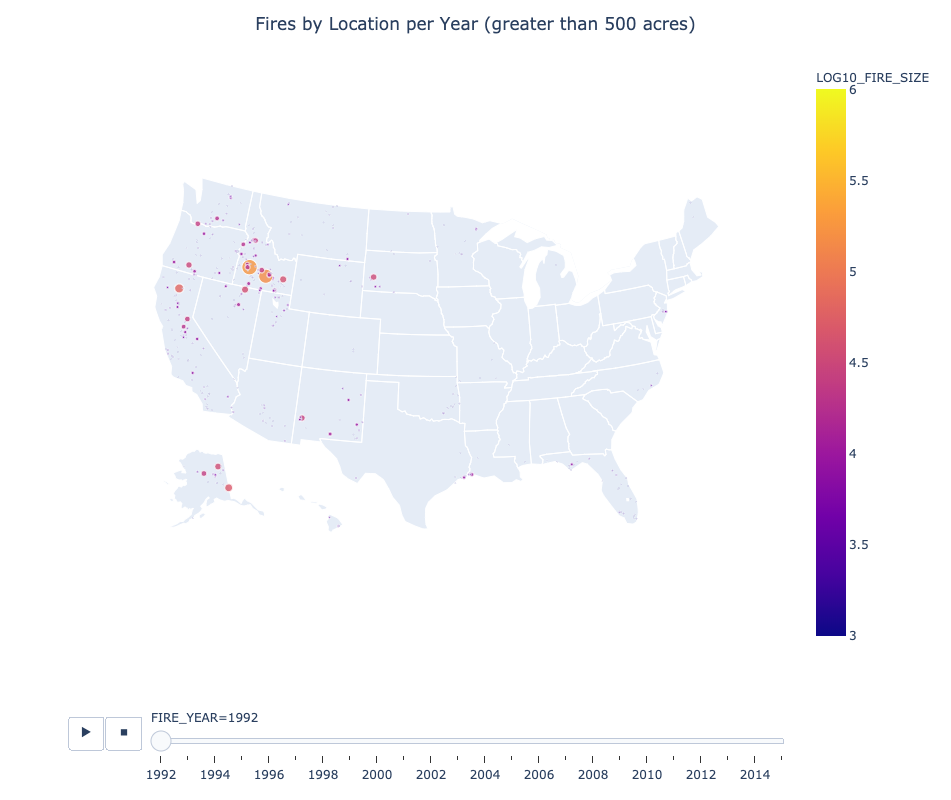

In [233]:
mask = (fpa['FIRE_SIZE']>500)
fig = px.scatter_geo(fpa[mask], 
                lat = 'LATITUDE', 
                lon = 'LONGITUDE',
                color = 'LOG10_FIRE_SIZE',
                range_color = [3,6],
                size = fpa[mask]['FIRE_SIZE'],
                opacity = 0.8,
                text = 'FIRE_NAME',
                animation_group = 'FIRE_YEAR',
                animation_frame = 'FIRE_YEAR',
                category_orders={'FIRE_YEAR':list(np.sort(fpa[mask]['FIRE_YEAR'].unique()))},
                locationmode = 'USA-states', 
                    height = 800)

fig.update_layout(geo_scope = 'usa', 
                  title = 'Fires by Location per Year (greater than 500 acres)', 
                  title_x=0.5, 
                  legend_title_text='Log10 Fire Size')